In this notebook, I want to put the ModelJawn sequence together so that it repeats itself:
1. randomly select 8 out of the 10 measurements
2. run the linear regression on the data
3. store the observed values (of discharge)
4. calculate the predicted values (of discharge)
5. calculate the residuals for the run
6. store in a dataframe:
    1. observations
    2. predictions
    3. residuals 
    for each run. 
7. also store: 
    1. the run number 
    2. the r2 value of the regression
    3. the slope and intercept of the regression
    4. might as well store the std_err and pvalue 
    
    
Re-iterate 5 times, then calculate the mean of the slopes and intercepts now stored in the dataframe.

Repeat until the mean values no longer change with successive iterations.

In [26]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import rcParams
import scipy.stats as stats 
import matplotlib.ticker as plticker
from scipy.optimize import curve_fit
import random
from rpy2.robjects import Vector

In [27]:
#Generate df of the observations
#DA is in km^2 and Q is in l/s
d={'DA':[82.450, 27.150, 16.275, 117.275, 382.975,
                              1596.280, 127.675, 9.44982, 2609.570, 3367.000], 
                             'Q':[8.662133483, 0.68431375, 0.868684824, 3.60222113,
                              7.995490543, 24.09174135, 8.038100597, 0.935,
                              119.5290555, 271.842]}
df = pd.DataFrame(data=d, dtype=float)
df

,DA,Q
0,82.45000,8.662133
1,27.15000,0.684314
2,16.27500,0.868685
3,117.27500,3.602221
4,382.97500,7.995491
5,1596.28000,24.091741
6,127.67500,8.038101
7,9.44982,0.935000
8,2609.57000,119.529055
9,3367.00000,271.842000


To start off, I am going to try this:
1. loop through the function 'some' 
2. append output lists to a new df

In [28]:
#randomly select a subset of the df
def some(foo, n):
    return foo.iloc[random.sample(foo.index, n)]
some(df,8)

,DA,Q
4,382.975,7.995491
9,3367.000,271.842000
0,82.450,8.662133
8,2609.570,119.529055
5,1596.280,24.091741
6,127.675,8.038101
1,27.150,0.684314
2,16.275,0.868685


In [29]:
# make a new df to store values
runs = pd.DataFrame(columns=['obs_val', 'pred_val','residual','slope','intercept','r2','id'])

In [30]:
for e in range(100):
    #selects a random sample
    k = some(df,8)

    x = np.array(k['DA'])
    y = np.array(k['Q'])
    
    #fits the data w a linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

    obs_values = y
    pred_values = []
    residuals = []
    
    #calculates the predicted values from the linear fit
    for i in x:
        pred_i = float(i) * float(slope) + float(intercept)
        pred_values.append(pred_i)

    #calculates the residual for each pair of observations
    for obs_v,pred_v in zip(obs_values,pred_values):
        Residual = float(obs_v - pred_v)
        residuals.append(Residual)
        
    temp_runs = pd.DataFrame()
    
    temp_runs['obs_val']=obs_values
    temp_runs['pred_val']=pred_values
    temp_runs['residual']=residuals
    temp_runs['slope']=slope
    temp_runs['intercept']=intercept
    temp_runs['r2']=r_value**2
    temp_runs['id']=e
    
    runs = runs.append(pd.DataFrame(data=temp_runs))

In [178]:
runs.describe()

,obs_val,pred_val,residual,slope,intercept,r2
count,800.000000,800.000000,8.000000e+02,800.000000,800.000000,800.000000
mean,45.138538,45.138538,4.218847e-16,0.062382,-8.452803,0.856963
std,83.552280,77.500988,3.121827e+01,0.011619,4.244024,0.036082
min,0.684314,-12.972457,-8.237451e+01,0.038006,-13.714715,0.830643
25%,0.935000,-4.942304,-4.246626e+00,0.064781,-11.978498,0.832829
50%,8.038101,0.823032,6.273677e+00,0.065951,-9.670954,0.840282
75%,24.091741,92.715890,1.185352e+01,0.069209,-4.272847,0.861046
max,271.842000,233.649628,6.344345e+01,0.072804,-0.413584,0.989645


In [231]:
tot_meanslope = runs['slope'].mean()
tot_meanintercept = runs['intercept'].mean()

In [184]:
#split by id
grouped = runs.groupby('id')

#create series with one value for slope, intercept, and r2
temp_slope = grouped['slope'].first()
temp_intercept = grouped['intercept'].first()
temp_r = grouped['r2'].first()

#new data frame with slope, intercept, r2 stored by id
line_data = pd.concat([temp_slope, temp_intercept, temp_r], axis=1)
line_data = pd.DataFrame(line_data, columns=('slope','intercept','r2'))
#line_data

In [226]:
for row in line_data:
    
    m = line_data['slope']
    b = line_data['intercept']
    
    y_values = [(m*x)+b for x in range(3500)]
    x_values = np.arange(len(y_values))

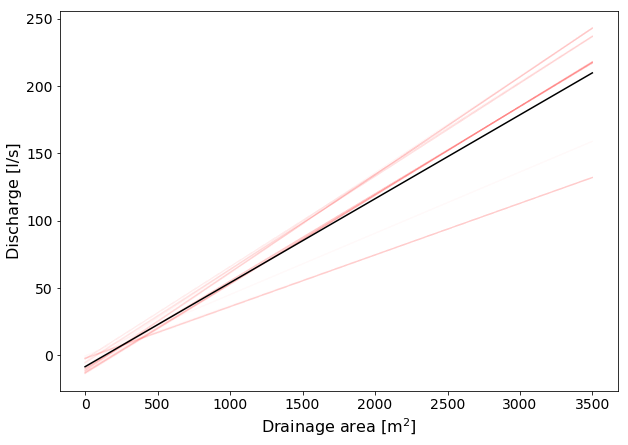

In [239]:
rcParams['figure.titlesize'] = 22
rcParams['axes.titlesize'] = 22
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['figure.subplot.wspace'] = 0.2

fig, ax = plt.subplots(figsize=(10,7))

plt.plot(x_values, y_values, linestyle='-', color='r', marker='', alpha=0.01)
plt.plot(x_values, (x_values*tot_meanslope)+tot_meanintercept, color='k')

ax.set_xlabel('Drainage area [m$^2$]')
ax.set_ylabel('Discharge [l/s]')
plt.show()

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    x_vals = np.arange(0,3500)
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals)

pd.concat *keys* allows for heirarchical index to be generated. i.e. keys=['1:50'] should label each 8-rows with sequential numbers from 1-50.

in r:
    runs['obs_val']=c(obs_values, kk) (where kk is the result of the interaction of the observed values) i.e. temp_obs_val 
    called a "vector" in r - but we couldn't find the equivalent
    
grouped.get_group(99)
Check the groupby transform methods for normalizing data

y_values = [m*x+b for x in range(3500)]